In [2]:
import pickle
import os
import pickle
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pandas.io import gbq
from google.cloud import bigquery
from google.oauth2 import service_account

%matplotlib inline
pd.set_option('display.max_colwidth', -1)
% config InlineBackend . figure_format = 'svg'

In [3]:
## Set up bigquery environment
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/shiqiyang/Dropbox/cs224w/Github224W-c6c2551f3816.json"
project_id = 'github224w'
client = bigquery.Client(project=project_id)
dataset_id = 'gh_data'
dataset_ref = client.dataset(dataset_id)
dataset = client.get_dataset(dataset_ref)

## Create view for user commit times since 2016

In [62]:
# query data: timestamps > 2016 and language = python
view_ref = dataset_ref.table('user_commit_counts_view')
view = bigquery.Table(view_ref)

view.view_query = ("""
#standardSQL
SELECT
  committer_id,
  COUNT(project_id) as project_counts
FROM
  `ghtorrent-bq:ght_2018_04_01.commits`
WHERE
  created_at > TIMESTAMP('2016-01-01 00:00:00')
  AND project_id IN (
  SELECT
    project_id
  FROM
    `ghtorrent-bq.ght_2018_04_01.project_languages`
  WHERE
    LANGUAGE = "python")
GROUP BY committer_id
ORDER BY project_counts DESC
""")

view = client.create_table(view)

In [63]:
# Retrieve data from the view
query_job = client.query("""
SELECT
  project_counts,
  COUNT(committer_id) as committer_counts
FROM
  `github224w.gh_data.user_commit_counts_view`
GROUP BY project_counts
ORDER BY committer_counts DESC
""")
results = query_job.result()
user_commits_count = results.to_dataframe()

In [115]:
user_commits_count.sort_values(by='project_counts', inplace=True)

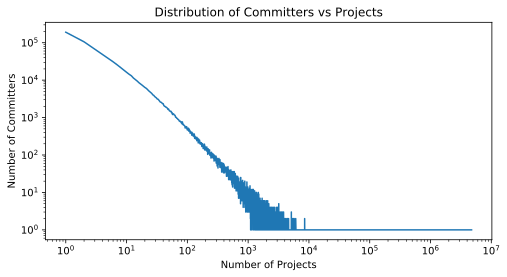

In [116]:
plt.figure(dpi=200, figsize=(8,4))
plt.plot(user_commits_count['project_counts'], user_commits_count['committer_counts'])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of Projects')
plt.ylabel('Number of Committers')
plt.title('Distribution of Committers vs Projects')
plt.show()

In [117]:
user_commits_count['perc']=user_commits_count['committer_counts']*1.0/sum(user_commits_count['committer_counts'])
user_commits_count['cum_sum'] = user_commits_count['perc'].cumsum()

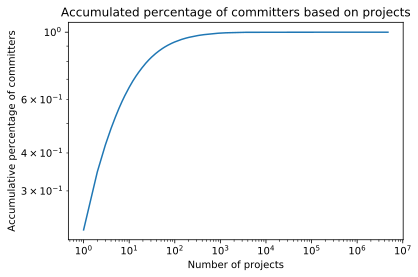

In [118]:
plt.plot(user_commits_count['project_counts'], user_commits_count['cum_sum'])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of projects')
plt.ylabel('Accumulative percentage of committers')
plt.title('Accumulated percentage of committers based on projects')
plt.show()

In [37]:
#count 
tail_count = sum(user_commits_count['committer_counts']==1)
active_count = sum(user_commits_count[(user_commits_count['project_counts']>=100)]['committer_counts'])


In [44]:
print ("Number of extremely active committers are: ",tail_count)
print ("Number of committers who have committed to more then 100 projects are: ",active_count)

Number of extremely active committers are:  1253
Number of committers who have committed to more then 100 projects are:  61358


## Create view for user commit times in the first quarter in 2016

In [47]:
view_ref = dataset_ref.table('user_commit_counts_view_2016_1')
view = bigquery.Table(view_ref)

view.view_query = ("""
#standardSQL
SELECT
  committer_id,
  COUNT(project_id) as project_counts
FROM
  `ghtorrent-bq:ght_2017_01_19.commits`
WHERE
  created_at > TIMESTAMP('2016-01-01 00:00:00')
  AND created_at < TIMESTAMP('2016-04-01 00:00:00')
  AND project_id IN (
  SELECT
    project_id
  FROM
    `ghtorrent-bq.ght_2017_01_19.project_languages`
  WHERE
    LANGUAGE = "python")
GROUP BY committer_id
ORDER BY project_counts DESC
""")

view = client.create_table(view)

In [49]:
query_job = client.query("""
SELECT
  project_counts,
  COUNT(committer_id) as committer_counts
FROM
  `github224w.gh_data.user_commit_counts_view_2016_1`
GROUP BY project_counts
ORDER BY committer_counts DESC
""")
results = query_job.result()
user_commits_count_2016_1 = results.to_dataframe()

In [50]:
user_commits_count_2016_1.sort_values(by='project_counts', inplace=True)
user_commits_count.tail()

,project_counts,committer_counts
1119,929,1
1120,926,1
1121,924,1
1122,922,1
1123,921,1


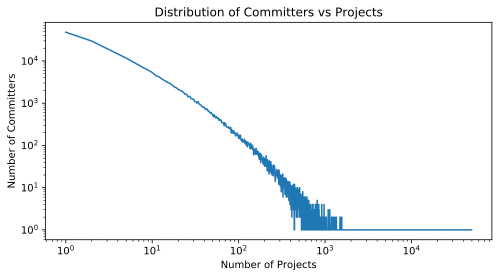

In [51]:
plt.figure(dpi=200, figsize=(8,4))
plt.plot(user_commits_count_2016_1['project_counts'], user_commits_count_2016_1['committer_counts'])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of Projects')
plt.ylabel('Number of Committers')
plt.title('Distribution of Committers vs Projects')
plt.show()

In [53]:
user_commits_count_2016_1['perc']=user_commits_count_2016_1['committer_counts']*1.0/sum(user_commits_count_2016_1['committer_counts'])
user_commits_count_2016_1['cum_sum'] = user_commits_count_2016_1['perc'].cumsum()


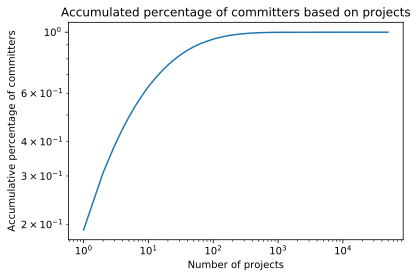

In [54]:
plt.plot(user_commits_count_2016_1['project_counts'], user_commits_count_2016_1['cum_sum'])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of projects')
plt.ylabel('Accumulative percentage of committers')
plt.title('Accumulated percentage of committers based on projects')
plt.show()

In [57]:
#count 
tail_count = sum(user_commits_count['committer_counts']==1)
active_count_10 = sum(user_commits_count[(user_commits_count['project_counts']>=10)]['committer_counts'])
active_count_100 = sum(user_commits_count[(user_commits_count['project_counts']>=100)]['committer_counts'])
print ("Number of extremely active committers are: ",tail_count)
print ("Number of committers who have committed to more than 10 projects are: ",active_count_10)
print ("Number of committers who have committed to more than 100 projects are: ",active_count_100)

Number of extremely active committers are:  382
Number of committers who have committed to more than 10 projects are:  97254
Number of committers who have committed to more than 100 projects are:  14303


## Create view for committers with more than 100 projects

In [68]:
#check sparsity: how many committers with more than 100 projects commit to the same project?
view_ref = dataset_ref.table('user_commit_counts100_view_2016_1')
view = bigquery.Table(view_ref)

view.view_query = ("""
#standardSQL
SELECT
  d1.committer_id,
  d1.project_counts,
  d2.project_id
FROM
  `github224w.gh_data.user_commit_counts_view_2016_1` d1
LEFT JOIN
   `ghtorrent-bq.ght_2017_01_19.commits`  d2
ON
  d1.committer_id = d2.committer_id
WHERE
  d1.project_counts >= 100
""")
view = client.create_table(view)

In [69]:
query_job = client.query("""
SELECT
  project_id,
  COUNT(committer_id) as committer_counts
FROM
  `github224w.gh_data.user_commit_counts100_view_2016_1`
GROUP BY project_id
ORDER BY committer_counts DESC
""")
results = query_job.result()
user_commits_count100_2016_1 = results.to_dataframe()

In [79]:
user_commits_count100_2016_1.head()

,project_id,committer_counts
0,20032639.0,593326
1,8372956.0,171546
2,789.0,152701
3,26557020.0,143045
4,1364059.0,125326


In [75]:
tail_count = sum(user_commits_count100_2016_1['committer_counts']==1)
row_count = user_commits_count100_2016_1.shape[0] 

In [80]:
print ("The proportion of projects with only one committers is :", tail_count*1.0/row_count)
print ("The number of projects with only one committers is:",tail_count )

The proportion of projects with only one committers is : 0.259248873684
The number of projects with only one committers is: 221888


## Create a view for watchers in the first quarter in 2016

In [92]:
view_ref = dataset_ref.table('watcher_counts_view_2016_1')
view = bigquery.Table(view_ref)

view.view_query = ("""
#standardSQL
SELECT
  d1.repo_id,
  COUNT(d1.user_id) as watchers_counts
FROM
  `ghtorrent-bq:ght_2017_01_19.watchers` d1
INNER JOIN
  `ghtorrent-bq.ght_2017_01_19.project_languages` d2
ON
  d1.repo_id = d2.project_id
WHERE
  d1.created_at > TIMESTAMP('2016-01-01 00:00:00')
  AND d1.created_at < TIMESTAMP('2016-04-01 00:00:00')
  AND d2.LANGUAGE = "python"
GROUP BY d1.repo_id
ORDER BY watchers_counts DESC
""")

view = client.create_table(view)

In [96]:
query_job = client.query("""
SELECT
  watchers_counts,
  COUNT(repo_id) as repos_count
FROM
  `github224w.gh_data.watcher_counts_view_2016_1`
GROUP BY 
  watchers_counts
""")
results = query_job.result()
watchers_count_2016_1 = results.to_dataframe()

In [103]:
watchers_count_2016_1.head()

,watchers_counts,repos_count
0,11656,1
224,808,1
350,349,1
223,816,1
351,345,1


In [107]:
watchers_count_2016_1.sort_values(by='watchers_counts', inplace=True)

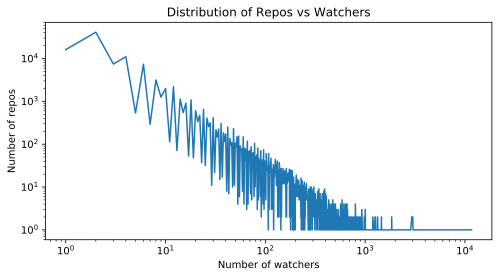

In [108]:
plt.figure(dpi=200, figsize=(8,4))
plt.plot(watchers_count_2016_1['watchers_counts'], watchers_count_2016_1['repos_count'])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of watchers')
plt.ylabel('Number of repos')
plt.title('Distribution of Repos vs Watchers')
plt.show()

In [112]:
watchers_count_2016_1['perc']=watchers_count_2016_1['repos_count']*1.0/sum(watchers_count_2016_1['repos_count'])
watchers_count_2016_1['cum_sum'] = watchers_count_2016_1['perc'].cumsum()

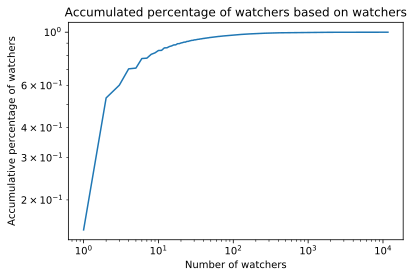

In [119]:
plt.plot(watchers_count_2016_1['watchers_counts'], watchers_count_2016_1['cum_sum'])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of watchers')
plt.ylabel('Accumulative percentage of watchers')
plt.title('Accumulated percentage of watchers based on watchers')
plt.show()

In [124]:
tail_count = sum(watchers_count_2016_1['repos_count']==1)
active_count_10 = sum(watchers_count_2016_1[(watchers_count_2016_1['watchers_counts']>=10)]['repos_count'])
inactive = sum(watchers_count_2016_1[(watchers_count_2016_1['watchers_counts']==1)]['repos_count'])
print ("Number of extremely popular repos are: ",tail_count)
print ("Number of repos with more than 10 watchers are: ",active_count_10)
print("Number of repos with only one watchers are: ",inactive)

Number of extremely popular repos are:  376
Number of repos with more than 10 watchers are:  19324
Number of repos with only one watchers are:  16140
